In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pymech
import os

from mayavi import mlab 
mlab.init_notebook() #ipy backend 
import k3d 

%matplotlib inline

from publication_plotstyle import *

Notebook initialized with ipy backend.


# Summary 

$$ Ra = 10^6 $$
$$ Pr = 0.7 $$
$$ \Delta T = 1 $$
$$\nu = 8.366600 \times 10^{-04}$$
$$\alpha = 1.195220 \times 10^{-03} $$

$$ Nelz = 32 $$
$$ \gamma = 1 $$
$$ D = H = 1 $$

### Nek5000 Simulation Stats 

For 10001 timesteps, from the stdout file:

total elapsed time             :   2.59047E+03 sec <br>
total solver time w/o IO       :   2.57572E+03 sec <br>
time/timestep                  :   2.57546E-01 sec <br>
avg throughput per timestep    :   1.07659E+05 gridpts/CPUs <br>
total max memory usage         :   8.75227E+01 GB

Using $48*8$ Stampede2 skx-normal queue

In [21]:
Ra = 1e6
Pr = 0.707
nelz = 32 # z direction discretization

H = 1.0; D = 1.0
deltaT = 1.0
nu = 8.366600E-04
alpha = 1.195220E-03

# for reading vertical means 

N = 7 # polynomial order 
N_nz = nelz*N 

# Reading data

In [22]:
# get all the run folder names
myruns = !ls 
myruns = [r for r in myruns if r.startswith("RUN")][:24]
print(myruns)
nruns = np.arange(1,len(myruns)+1,dtype = int)

['RUN1', 'RUN2', 'RUN3', 'RUN4', 'RUN5', 'RUN6', 'RUN7', 'RUN8', 'RUN9', 'RUN_10', 'RUN_11', 'RUN_12', 'RUN_13', 'RUN_14', 'RUN_15', 'RUN_16', 'RUN_17', 'RUN_18', 'RUN_19', 'RUN_20', 'RUN_21', 'RUN_22', 'RUN_23', 'RUN_24']


In [23]:
# Read all Nusselt numbers for all runs 
Nusselt = {}
for i,run in zip(nruns,myruns):
    Nusselt[i] = np.loadtxt(run+'/Nusselt.dat',usecols=[0,*range(2,6)])
    
print('***** 1st row of Nusselt must match *****')
print(Nusselt[15][0])
!head -1 RUN_15/Nusselt.dat


***** 1st row of Nusselt must match *****
[1.000000e+00 2.779231e+01 1.069412e-04 1.002760e+01 8.948328e+00]
     1 Nusselt  2.779231E+01  1.069412E-04  1.002760E+01  8.948328E+00


In [24]:
# Read all vertical data for all runs

ver_dtdz, ver_epst, ver_epsv, = {},{},{}  # dicts
ver_temp, ver_uzte = {},{} # dicts
for i,run in enumerate(myruns,1):
    #fver = !ls $run/ver*    # use bash to get folder inputs and then call in ver* -- $ to sue python vars inside this!
    fver = ['./' + run + '/' + f + '.dat' for f in ['ver_dtdz', 'ver_epst', 'ver_epsv', 'ver_temp', 'ver_uzte']]
    
    for f,ver in zip(fver, [ver_dtdz, ver_epst, ver_epsv, ver_temp, ver_uzte]):
        ver[i] = np.loadtxt(f,unpack = True)    # Nxt time do not unpack. 

#delete unnecessary variables 
del fver
del ver 

- Data from RUN_17 for Nu.dat and DT.dat are cut out from step 90,001. The data overlaps with RUN_18. RUN_17 could not complete all the required timesteps and RUN_18 had to restart from RUN_17's 90,000 timestep. 

In [25]:
''' INPUT FROM REA FILE '''
# iosteps for the different runs, obtained from the rea files for each run. 
# Only at these intervals the vertical means are calculated. 
# change this to become automatic. 

iostep = [
            250, 500, 500, 
            500, 500, 500, 
            1000, 1000, 1000, 
            1000, 1000, 2000, 
            2000, 500, 1000,
            4000, 10000, 10000, 
            10000, 2000, 10000,
            10000, 10000, 10000         
        ] 

endstep = [
            3000, 1000, 1000,
            1000, 2000, 2000, 
            5000, 5000, 10000, 
            10000, 10000, 20000,
            20000, 500, 10000,
            40000, 90000, 120000,    # the run ended abruptly RUN_17= 100,000 - > 90,000
            130000, 8000, 120000,    # RUN ended abruptly for RUN_20 10000 --> 8000
            120000, 120000, 120000
        ]

In [26]:
# had to make iotimesteps as a dictionary - for indexing 

iotimesteps = {i+1:np.arange(io,end+1,io) for i,(io,end) in enumerate(zip(iostep,endstep))}
print('*** These are the timesteps for which the vertical means are calculated ***')
print(*iotimesteps.values(), sep = '\n')

print()
print()

# find the times at which the vert_means are written
# Taking the times from Nusselt.dat 
# iotimesteps[run] - 1 is required. 

times = {}
for run in nruns:
    times[run] = Nusselt[run][:,1][iotimesteps[run]-1] # index using array works with np
    
print('*** These are the times for which the vertical means are calculated ***')
print(*times.values(), sep = '\n')

# delete unneeded dictionaries 
# del iotimesteps

*** These are the timesteps for which the vertical means are calculated ***
[ 250  500  750 1000 1250 1500 1750 2000 2250 2500 2750 3000]
[ 500 1000]
[ 500 1000]
[ 500 1000]
[ 500 1000 1500 2000]
[ 500 1000 1500 2000]
[1000 2000 3000 4000 5000]
[1000 2000 3000 4000 5000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000 20000]
[ 2000  4000  6000  8000 10000 12000 14000 16000 18000 20000]
[500]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[ 4000  8000 12000 16000 20000 24000 28000 32000 36000 40000]
[10000 20000 30000 40000 50000 60000 70000 80000 90000]
[ 10000  20000  30000  40000  50000  60000  70000  80000  90000 100000
 110000 120000]
[ 10000  20000  30000  40000  50000  60000  70000  80000  90000 100000
 110000 120000 130000]
[2000 4000 6000 8000]
[ 10000  20000  30000  40000 

### Check whether data read is correct or not

1. **Nusselt Number** 
1. **ver_temp** 
1. **ver_uzte**

In [27]:
# block to check whether data is read correctly ....
run = 5
tm = 18.57988
iloc = np.where(times[run] == tm)[0][0] + 1
ver_data = ver_uzte[run][1, (iloc - 1)*N_nz : iloc*N_nz]

#print(iloc) #right 
#print((iloc - 1)*N_nz) #
#print(ver_data)

del tm
del run

***
# Nusselt Number Statistics

1. **Plot of Nusselt Number plots from stdout file**
1. **Check whether $\frac{\partial \left < T \right >}{\partial z}$ is equal to the mean profiles.**
1. **Calculate, Verify and Plot Nu calculated vs stdout**
1. **Plot of ratio of Nusselt(stdout) with Nusselt(calc.) for z = 0, z = 1**
1. **Calculate Volumetric Nusselt Number**
1. **Plot of Nusselt number at z = 0,0.5,1**
1. Fourier/Chebyshev/Legendre modes of mean profiles 
1. Find out where Nu is negative, plot uzt and dtdz for that case.


In [28]:
# stack all of them vertically now - and run this only once

for run in nruns:
    Nusselt[run] = np.column_stack(Nusselt[run])   

In [29]:
''' FREE FALL TIME UNITS 
- By Non dimensionalization of parameters, both Uf and Tf are to be equal to 1.
'''

Uf = nu*np.sqrt(Ra/Pr) # free fall velocity 
Tf = H/Uf
print(f'Free Fall Velocity = {Uf} \t Free Fall Time = {Tf}') 

Free Fall Velocity = 0.9950371586530949 	 Free Fall Time = 1.0049875939845532


### Plot of Nusselt Number plots from stdout file

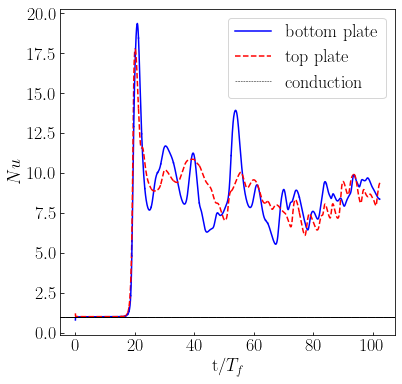

In [30]:
# Plotting the Nusselt Number against time, from Nusselt.dat
# Non dimensional time on x-axis with Tf

plt.figure(figsize=[6,6])
plt.xlabel('t/$T_f$')
plt.ylabel(r'$Nu$')
    
for run in nruns:
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][3], 'b-' )
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][4], 'r--')
    plt.axhline(y=1,color = 'k',linestyle='--',linewidth=0.5)
plt.legend(['bottom plate','top plate','conduction'])

plt.savefig('Figures/Nusselt.pgf')
# plot restart times here if needed.


***
### Check whether $\frac{\partial \left < T \right >}{\partial z}$ is equal to the mean profiles from the RUNS.

- 2nd order Finite difference scheme used at all points in domain 

- 1st order at boundaries

223
all z values are <=1 : True
relative error =  0.0005446852449790078


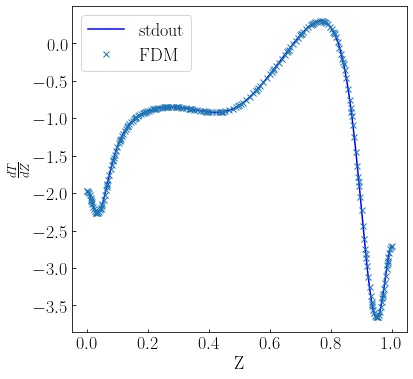

In [31]:
# take any single run
run = 5
timestep = 1500; iloc = np.where(iotimesteps[run] == timestep)[0][0] + 1
dTdz_stdout = ver_dtdz[run][1,(iloc-1) * N_nz : iloc * N_nz]
T_stdout = ver_temp[run][1,(iloc-1) * N_nz : iloc * N_nz]

# find z, delta z
Z = ver_temp[1][0][0:N_nz]
dz = Z[1:] - Z[:-1]; print(len(dz))
print('all z values are <=1 :', Z.all() <=1 )

plt.figure(figsize = [6,6])
plt.plot(Z,dTdz_stdout,'b',label = 'stdout')
plt.xlabel('Z')
plt.ylabel(r'$\frac{dT}{dZ}$')

dTdz_cal = np.zeros_like(Z)

# First order at boundaries 
dTdz_cal[0] =  (T_stdout[1] - T_stdout[0])/dz[0]
dTdz_cal[-1] = (T_stdout[-1] - T_stdout[-2])/dz[-1]

# Second order at all other points
for iz, (zb,z,zf) in enumerate(zip(Z[:-2],Z[1:-1],Z[2:]), 1):
    
    rb = - (zf - z)/( (z - zb) * (zf - zb) ) 
    rz  = + (zf - 2*z + zb)/( (zf - z) * (z - zb))
    rf = + (z - zb)/( (zf - z) * (zf - zb) )
    
    Tb, Tz, Tff = T_stdout[iz-1:iz+2]
    dTdz_cal[iz] = rb * Tb + rz * Tz + rf * Tff
    
plt.plot(Z, dTdz_cal, 'x', label = 'FDM')
plt.legend()

''' ********** YAY! THE PLOTS ARE NEAR PERFECT FIT WITH EACH OTHER ******** '''

print('relative error = ', 
         (np.linalg.norm(dTdz_cal - dTdz_stdout)/np.linalg.norm(dTdz_stdout)  )
     )

del rb, rf, rz
del Tb, Tff, Tz # Tf caused a lot of problem lol 
del iz 

***
### Calculate, Verify and Plot Nu calculated vs stdout

$$ 
Nu(z,t) = \sqrt{Ra Pr} \left <u_z T \right > _{A} - \frac{\partial \left <T \right>_{A}}{\partial z}
$$

- $\left <u_z T \right > _{A}$ is the horizontal average at each z, and is a function of time. 


- $ \frac{\partial \left <T \right>_{A}}{\partial z} $ is taken from the vertical means file ver_dtdz. 


- Eq. (10) from [Resolving the fine-scale structure in turbulent Rayleigh–Bénard convection](https://iopscience.iop.org/article/10.1088/1367-2630/15/11/113063/pdf)


In [32]:
# function to calculate the Nusselt number at a given time(step) t and a given time z 
# using formula

def Nusselt_where(run, timestep, z_step): 
    ''' 
    run : which run we want the profile
    timestep : can be from one of the list of iotimesteps above 
    z_step : is which z-layer; z-values at the layer not required.
    z-step : 1 -> N_nz 
    Nusselt can only be calculated for the times which DT DZ file is written 
    '''
    
    # find out all timestep locs
    iloc = list(iotimesteps[run]).index(timestep) + 1
    
    # take out all z data for timestep given
    ut = ver_uzte[run][1,(iloc - 1) * N_nz : iloc * N_nz][z_step-1]
    dd = ver_dtdz[run][1,(iloc - 1)*N_nz : iloc*N_nz][z_step-1]
    Nu = np.sqrt(Ra*Pr) * ut  - dd
    
    return Nu
     
# this is a goddamn 2 line function, who knew. 30 mins to do this!!


In [33]:
print(Nusselt_where(12,2000,1)) # bot
print(Nusselt_where(12,2000,N_nz//2)) #mid
print(Nusselt_where(12,2000,N_nz)) #top 

8.64971913569996
4.349627832016641
10.32605235354203


In [34]:
z_top,z_bot = N_nz, 1
Nusselt_top, Nusselt_bottom = [],[]

for r in nruns:
    for t in iotimesteps[r]:
        Nusselt_top.append(Nusselt_where(r, t, z_top))
        Nusselt_bottom.append(Nusselt_where(r, t, z_bot))

Nusselt_top = np.array(Nusselt_top)       # imp.
Nusselt_bottom = np.array(Nusselt_bottom) # imp.

Comparing the Nusselt numbers using the norm of the Nusselt number containing vectors:


$$ 
\Lambda_{Nu} = \frac{ || Nu_{cal} - Nu_{stdout} ||}{|| Nu_{stdout}|| }
$$

In [35]:
# verify that the nusselt numbers obtained from the equation is ~ Nu from stdout
# find Nusselt numbers from stdout for those where times are written out

overall_times = np.concatenate([times[r] for r in nruns]) # This is an important variable for plotting 

Nusselt_top_stdout = []
Nusselt_bot_stdout = []

for run in nruns:
    for time_stdout, nbot, ntop in zip(Nusselt[run][1],Nusselt[run][3],Nusselt[run][4]):
        if time_stdout in overall_times:
            Nusselt_top_stdout.append(ntop)
            Nusselt_bot_stdout.append(nbot)
                  
#### THIS IS SPECIFICALLY FOR NUSSELT NUMBERS for RUN 24. ##### 
            
Nusselt_top_stdout = np.array(Nusselt_top_stdout)[:-1] # imp. 
Nusselt_bot_stdout = np.array(Nusselt_bot_stdout)[:-1]# imp. 
            
print('relative norm top plate: ', 
      np.linalg.norm(Nusselt_top - Nusselt_top_stdout)/np.linalg.norm(Nusselt_top_stdout)
     )
print('relative norm bottom plate:', 
      np.linalg.norm(Nusselt_bottom - Nusselt_bot_stdout)/np.linalg.norm(Nusselt_bot_stdout)
     )

""" VERIFIED THAT THE STDOUT FILE Nu MATCHES WITH CALCULATIONS """

relative norm top plate:  0.00010913625014396744
relative norm bottom plate: 2.0811476341775874e-07


' VERIFIED THAT THE STDOUT FILE Nu MATCHES WITH CALCULATIONS '

In [36]:
print(Nusselt_top_stdout[-5:])
print(Nusselt_top[-4:])
print(len(overall_times))

[8.631236 8.369554 7.989925 8.741302 9.39026 ]
[8.36943876 7.9897749  8.74182607 9.39040741]
193


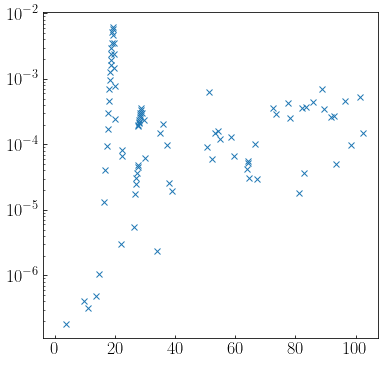

In [37]:
# Why is the error for the top plate so large compared to bottom?

plt.figure(figsize = [6,6]) 
plt.semilogy(overall_times/Tf, Nusselt_top - Nusselt_top_stdout,'x')

/Users/achu/W2/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


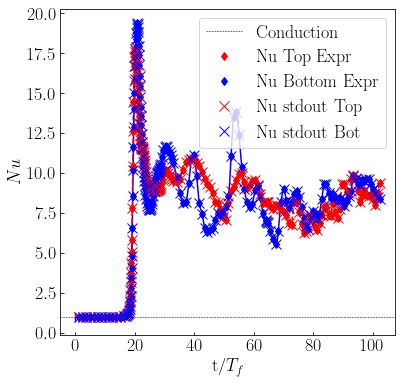

In [38]:
# Plot Nusselt.dat along with obtained equation
# Verify that the calculated Nu stands well with the stdouts

plt.figure(figsize=[6,6])
plt.xlabel('t/$T_f$')
plt.ylabel(r'$Nu$')
    
for run in nruns:
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][3], 'b-' , label = None)
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][4], 'r--', label = None)
    
plt.axhline(y=1,color = 'k',linestyle='--',linewidth=0.5, label = 'Conduction')

# Nu calculated 
plt.plot(overall_times/Tf, Nusselt_top, 'd', color = 'r', label = 'Nu Top Expr')
plt.plot(overall_times/Tf, Nusselt_bottom, 'd', color = 'b', label = 'Nu Bottom Expr')

#Nu stdout 
plt.plot(overall_times/Tf, Nusselt_top_stdout, 'x', color = 'r', 
         markersize = 10, label = 'Nu stdout Top')
plt.plot(overall_times/Tf, Nusselt_bot_stdout, 'x', color = 'b', 
         markersize = 10, label = 'Nu stdout Bot')
  
plt.legend()


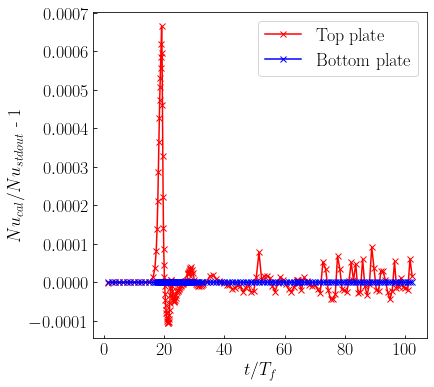

In [39]:
# Plot the ratio of Nusselt Number from stdout vs calculated 

plt.figure(figsize = [6,6])
plt.xlabel('$t/T_f$'); plt.ylabel('$Nu_{cal}/Nu_{stdout}$ - 1')

plt.plot(overall_times/Tf, Nusselt_top/Nusselt_top_stdout -1,'rx-', label = 'Top plate')
plt.plot(overall_times/Tf, Nusselt_bottom/Nusselt_bot_stdout -1,'bx-', label = 'Bottom plate')
plt.legend()


***
### Calculate Volumetric Nusselt Number 

The Nusselt number can be found by volume averaging in the steady state: 

$$
Nu_{V,t} = 1 + \sqrt{Ra Pr} \left < u_z T\right >_{V,t} 
$$

where, 

$$
\left < u_z T\right >_{V,t} = \frac{\int_t \int_{Z} \left < u_z T\right >_{A}(z,t) dz dt}{\int dz \int dt}
$$ 

In [40]:
# when does steady state start?

steady_start = 22
steady_states = np.array(list(filter( lambda x : x >= steady_start, overall_times)))
print('steady state times are : \n', *steady_states)   


steady state times are : 
 22.07085 22.1778 22.28474 22.39168 22.49862 22.60556 22.7125 22.81944 22.92638 23.03333 23.14027 23.24721 23.35415 23.46109 23.67497 23.88885 24.10274 24.31662 24.5305 24.74438 24.95827 25.17215 25.38603 25.59991 25.8138 26.02768 26.24156 26.45544 26.66932 26.88321 27.09709 27.31097 27.52485 27.73874 27.79221 27.89915 28.00609 28.11303 28.21997 28.32691 28.43385 28.5408 28.64774 28.75468 28.86162 29.28938 29.71715 30.14491 30.57268 31.00044 31.42821 31.85597 32.28374 32.7115 33.13927 34.20868 35.27809 36.3475 37.41691 38.30329 39.18081 40.06335 40.9629 41.862 42.75845 43.6549 44.55135 45.4478 46.34425 47.2407 48.13715 49.0336 49.93005 50.8265 51.72295 52.6194 53.51585 54.4123 55.30875 56.2052 57.10165 57.9981 58.89455 59.791 60.68745 61.5839 62.48035 63.3768 64.27325 64.45254 64.63183 64.81112 64.99041 65.88686 66.78331 67.67976 68.57621 69.47266 70.36911 71.26556 72.16201 73.05846 73.95491 74.85136 75.66849 76.42941 77.19033 77.95125 78.71217 79.47309 80.234

#### Check that trapezoidal rule works the way I code it : 

In [41]:
# dummy to play with integration by trapezoidal rule 

dx = 1e-2
x = np.arange(0,2*np.pi+dx,dx)
y = np.ones_like(x) #np.sin(x)

delta_x = x[1:] - x[:-1] 
delta_y = y[1:] - y[:-1]

area = np.sum(0.5 * delta_x * (y[:-1] + y[1:]) )
print(area)

6.29


In [42]:
# find the volume average temp flux
# Z, dz are defined above in another cell
# integrations are trapezoidal rule 

uzt_V_t = []

for run in nruns:
    for iloc,t in enumerate(times[run],1):
        uzt = ver_uzte[run][1,(iloc - 1)*N_nz:iloc*N_nz]        
        uzt_sum = 0.0
        if t in steady_states:
            uzt_sum = 1/H * np.sum(0.5*(uzt[:-1]+uzt[1:]) * dz) 
            uzt_V_t.append(uzt_sum)

# this is very in-accurate result because dt is very large
# Then how do you calculate the Nusselt number over time?

uzt_V_t = np.array(uzt_V_t)
dt_ss = steady_states[1:] - steady_states[:-1]
uzt_vol = 1./(steady_states[-1] - steady_states[0]) * (
                np.sum( 0.5*( uzt_V_t[1:]+uzt_V_t[:-1] )*dt_ss )      )

Nu_vol_avg = 1. + np.sqrt(Ra*Pr)*uzt_vol
print('Volume averaged Nusselt Number = ', Nu_vol_avg)

Volume averaged Nusselt Number =  8.642667795769071


***
### Final Plot of Nu with all the above results

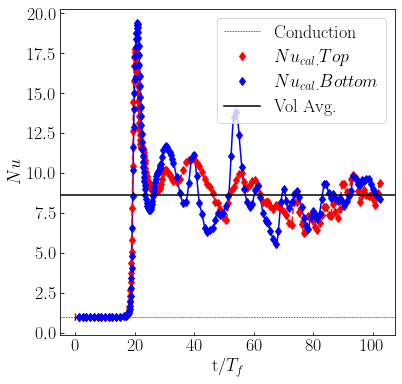

In [43]:
# Plot Nusselt.dat along with obtained equation

plt.figure(figsize=[6,6])
plt.xlabel('t/$T_f$')
plt.ylabel(r'$Nu$')
    
for run in nruns:
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][3], 'b-', label = None )
    plt.plot(Nusselt[run][1]/Tf, Nusselt[run][4], 'r--', label = None)

plt.axhline(y=1,color = 'k',linestyle='--',linewidth=0.5, label = 'Conduction')
plt.plot(overall_times/Tf, Nusselt_top, 'd', color = 'r', label = '$Nu_{cal.} Top$')
plt.plot(overall_times/Tf, Nusselt_bottom, 'd', color = 'b', label = '$Nu_{cal.} Bottom$')
plt.axhline(y = Nu_vol_avg,color = 'k', label = 'Vol Avg.')

plt.legend()

#plt.legend(['bottom plate','top plate','conduction'])


***
### Plot of Nusselt number at z = 0, 0.5, 1 for all times

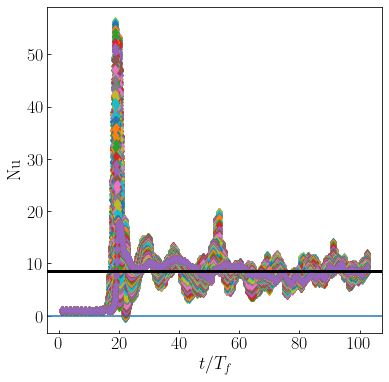

In [44]:
# plot the nusselt number at any given (I/O)time and at any given z

# input z
#z_arr = np.array([1, N_nz//2, N_nz]) # rational fraction of N_nz is possible 
z_arr = np.arange(1,N_nz+1,3)
nu = []

plt.figure(figsize = [6,6])
plt.xlabel('$t/T_f$'); plt.ylabel('Nu')
for z in z_arr:
    nu = [Nusselt_where(run,time,z) for run in nruns for time in iotimesteps[run]]
    plt.plot(overall_times/Tf, nu, 'd-', label = 'z = {:.2f}'.format((z-1)/N_nz) )
#plt.legend(loc=2)

plt.axhline(y = 0)
plt.axhline(y = Nu_vol_avg, color = 'k', linewidth = 3)

***
***
# Vertical Mean Statistics

- Nothing here. Usually, this is run if we are to verify something.
- The function plot_vert below is substantial. 

In [45]:
# function to plot all vertical means if necessary

def plot_vert(ver, name):
    
    plt.figure(figsize = [15, (len(nruns) + len(nruns)%2 )//2 * 7])
    for run in nruns:
        plt.subplot(len(nruns)//2 + len(nruns)%2 ,2,run)
        plt.ylabel(name); plt.xlabel('z/H')
        plt.title(f'RUN {run}')
        
        data_mean = np.zeros([N_nz])
        
        for i,t in enumerate(times[run],1):
            
            # 224 = 32*7, after 224 lines, z resets, capturing that effect here
            data_each_time = [ ver[run][0, (i-1)*N_nz:i*N_nz], ver[run][1,(i-1)*N_nz:i*N_nz] ]
            data_mean += data_each_time[1]
            plt.plot (data_each_time[0], data_each_time[1], '-', color='b',
                      linewidth = 0.7,
                      label = 'Run {} Time {}'.format(run,t))
            
        # plot the mean of all times
        data_mean = data_mean/len(times[run])
        plt.plot(data_each_time[0], data_mean,'r-', label = 'Mean')
        plt.savefig('./Figures/'+name + '.eps') #pgf as well?
        #plt.legend()


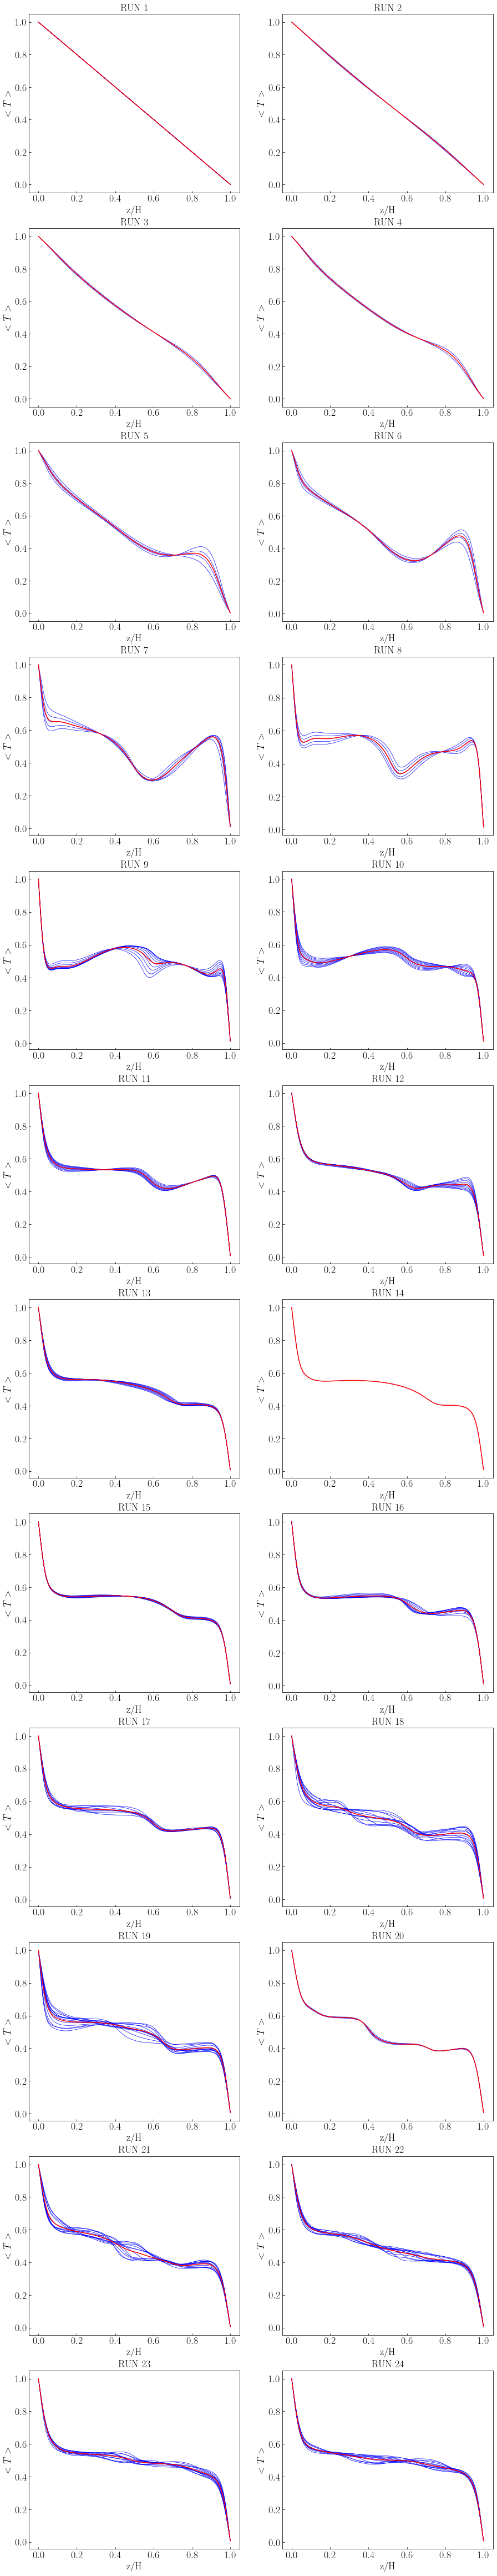

In [46]:
plot_vert(ver_temp, r'$<T>$')

***
## Error Analysis 

Similar to Stevens et al, we use the following equations to test different grid resolutions and quantify the amount of error in our simulation :


$$
\Lambda_T(t) = \frac{\sqrt{Ra Pr} \left <\epsilon_T \right>_{V} - Nu}{Nu}
$$

$$
\Lambda_v(t) = \frac{\sqrt{Ra Pr} \left <\epsilon \right>_{V} - (Nu-1)}{(Nu-1)}
$$

We plot these as a function of time; we do a volume average for the quantities. 

Volume averages are calculated as :

$$
\left <\epsilon \right>_{V} = \frac{1}{H}\int_0 ^H \left <\epsilon \right>_{Z} dz
$$

In [47]:
# get each quantity as a vol.avg, but as a fn. of time. 
# uses trapezoidal rule

Nu_vol_in_time = np.array([])
epsv_vol_in_time = np.array([])
epst_vol_in_time = np.array([])

# Vol. avg. Nu
uzt_V_t = np.array([])

for run in nruns:
    for iloc,t in enumerate(times[run],1):
        uzt = ver_uzte[run][1,(iloc - 1)*N_nz:iloc*N_nz]
        epst = ver_epst[run][1,(iloc - 1)*N_nz:iloc*N_nz]
        epsv = ver_epsv[run][1,(iloc - 1)*N_nz:iloc*N_nz]

        #if t in steady_states: Change indent if finding for steady states
        uzt_sum = 1/H * np.sum(0.5*(uzt[:-1]+uzt[1:]) * dz) 
        epst_sum = 1/H * np.sum(0.5*(epst[:-1]+epst[1:]) * dz)
        epsv_sum = 1/H * np.sum(0.5*(epsv[:-1]+epsv[1:]) * dz)                       
            
        uzt_V_t = np.append(uzt_V_t,uzt_sum)
        epst_vol_in_time = np.append(epst_vol_in_time, epst_sum)
        epsv_vol_in_time = np.append(epsv_vol_in_time, epsv_sum)
            
Nu_vol_in_time = 1 + np.sqrt(Ra*Pr) * uzt_V_t  
#print(Nu_vol_in_time,'\n', epst_vol_in_time,'\n', epsv_vol_in_time)


del uzt, uzt_sum, uzt_V_t
del epst, epsv, epst_sum, epsv_sum 

#### Check whether *trapezoidal rule* works against a simple reimman sum for $<u_zt>$

Compare the following 2 quantities:

1. $$
\left< u_z T \right>_{vol}(t) = \sum_{i = 1} ^{N_{nz}-1} \frac{(\left< u_z T \right>_{i} + \left< u_z T \right>_{i+1} )}{2} \Delta z_{i} 
$$

vs 

$$
\left< u_z T \right>_{vol}(t) = \sum_{i = 1} ^{N_{nz}-1} \left< u_z T \right>_{i} \Delta z_{i}
$$

Find out how well the quadrature works. 



2. Find out the volume of the cylinder using the same quadrature and prove that it works


0.0007071597254626472
0.0004471776024682156


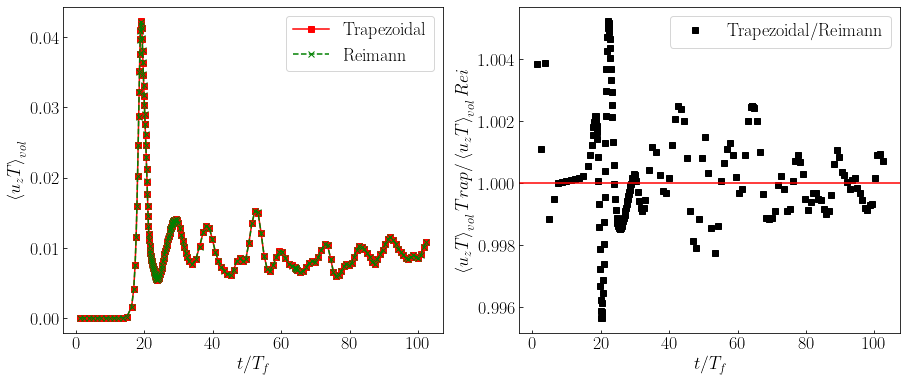

In [48]:
# 2. Volume of the cylinder using quadrature 

cyl_vol = np.pi * (D/2)**2 * np.sum(dz)
print(np.abs(cyl_vol - np.pi/4)) 

# 1. compare uzt 

uzt_v_trap = np.array([])
uzt_v_rei = np.array([])
uzt_sum_trap, uzt_sum_rei = 0.0, 0.0

for run in nruns:
    for iloc,t in enumerate(times[run],1):
        
        uzt = ver_uzte[run][1,(iloc - 1)*N_nz:iloc*N_nz]
        uzt_sum_trap = 1/H * np.sum(0.5*(uzt[:-1]+uzt[1:]) * dz)
        uzt_sum_rei = 1/H * np.sum(uzt[:-1] * dz) 
        
        uzt_v_trap = np.append(uzt_v_trap, uzt_sum_trap )
        uzt_v_rei  = np.append(uzt_v_rei, uzt_sum_rei)
    
plt.figure(figsize = [15,6])
plt.subplot(1,2,1)
plt.xlabel('$t/T_f$')
plt.ylabel(r'$ \left < u_z T\right >_{vol} $')
plt.plot(overall_times/Tf, uzt_v_trap, 'rs-', label = 'Trapezoidal')
plt.plot(overall_times/Tf, uzt_v_rei, 'gx--', label = 'Reimann')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('$t/T_f$')
plt.ylabel(r'$ \left < u_z T\right >_{vol} Trap / \left < u_z T\right >_{vol} Rei $')
plt.plot(overall_times/Tf, 
        uzt_v_trap/uzt_v_rei,'ks', label = 'Trapezoidal/Reimann')
plt.axhline(y = 1, color = 'r')
plt.legend()

print(np.linalg.norm(uzt_v_trap - uzt_v_rei))

***

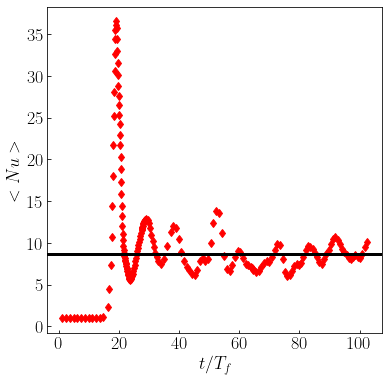

In [49]:
# Plot Variation of Nusselt number volume avg in time

plt.figure(figsize = [6,6])
plt.xlabel('$t/T_f$'); plt.ylabel('$<Nu>$')
plt.plot(overall_times/Tf, Nu_vol_in_time, 'rd', label = 'Nu vol avg')
plt.axhline(y = Nu_vol_avg, color = 'k', linewidth = 3)


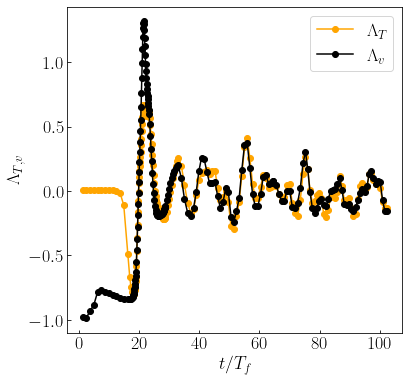

In [50]:
# plot the errors

Lambda_T = np.sqrt(Ra*Pr) * epst_vol_in_time/Nu_vol_in_time - 1
Lambda_v = np.sqrt(Ra*Pr) * epsv_vol_in_time/(Nu_vol_in_time - 1) - 1

plt.figure(figsize = [6,6])
plt.xlabel('$t/T_f$'); plt.ylabel('$\Lambda_{T,v}$')
plt.plot(overall_times/Tf, Lambda_T, 'o-', label = '$\Lambda_T$', color = 'orange')
plt.plot(overall_times/Tf, Lambda_v, 'ko-', label = '$\Lambda_v$')
plt.legend() 

## The Kolmogorov and Batchelor scales with numerical resolution

We find the Kolmogorov and Batchelor small scales for the given set of parameters, and plot as a function of z the variation of these scales. 

The classical averaged scale definitions are: 

$$
\left < \eta_K \right > = \left ( \frac{Pr^2 }{Ra (Nu - 1)} \right ) ^{1/4}
$$

$$
\left < \eta_B \right > = \left ( \frac{ 1 }{Ra (Nu - 1)} \right ) ^{1/4}
$$

Also, at any point, 


$$
\left < \eta_K (z) \right > = \frac{Pr^{3/8}}{Ra^{3/8}}\left < \epsilon(z) \right >_{A,t} ^{-1/4}
$$

The classical Grotzbach criterion is :

$$
\frac{\Delta z(z)}{\left< \eta_K (z) \right >_{A,t}} \leq \pi
$$


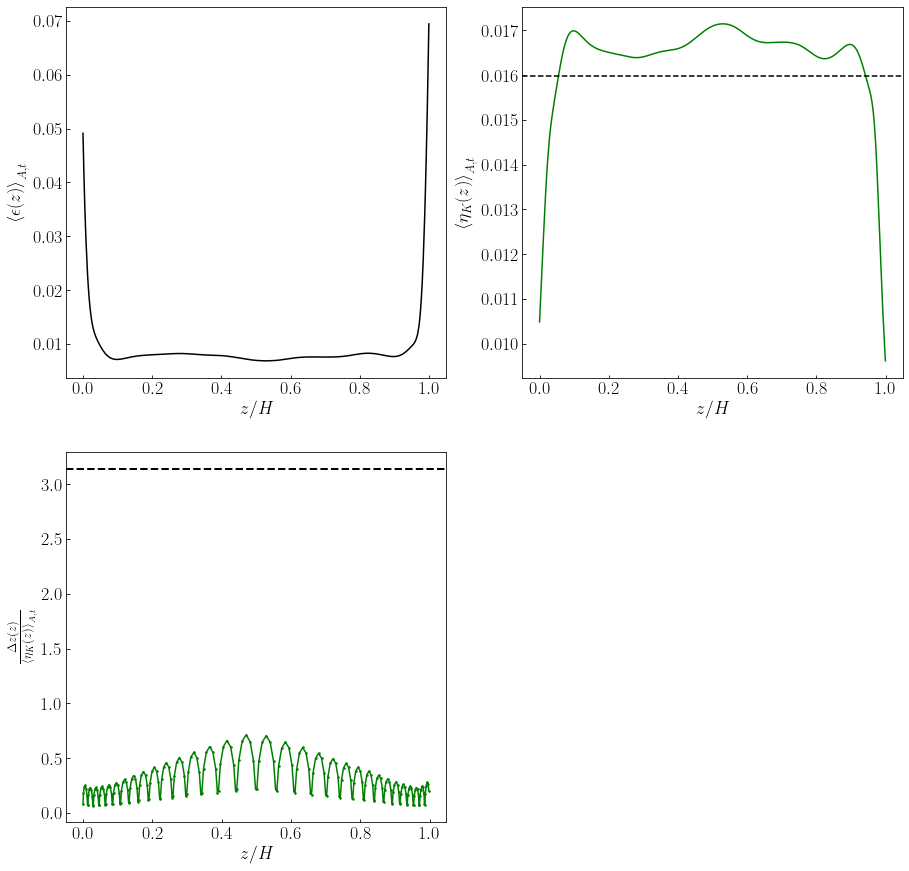

In [51]:
# plot the kinetic energy dissipation 
# plot the Kolmogorov scale dissipation 
# plot delta z/eta(z) ans compare with Grotzbach criterion 

epsv_avg = np.zeros([N_nz])

for run in nruns:
    for iloc,t in enumerate(times[run],1):
        if t in steady_states[:-1]: # run the loop excluding last for trap. rule integral 
            
            # average epsilon values over steady states
            epsv = ver_epsv[run][1,(iloc - 1)*N_nz: iloc*N_nz]
            epsv_next = ver_epsv[run][1,(iloc)*N_nz : (iloc + 1)*N_nz] 
            
            if epsv_next.size == 0:
                epsv_next = ver_epsv[run+1][1,0*N_nz : 1*N_nz]
                
            # very bad way of getting dt; unreadable code :(
            dt = steady_states[np.where(steady_states == t)[0][0] + 1] - t
            epsv_avg += (epsv + epsv_next)/2 * dt # sum up all integrands this way. 
            
epsv_avg = epsv_avg/(steady_states[-1] - steady_states[0])

# Kolmogorov scaling 
eta_K = ( Pr**(3/8) / Ra**(3/8) ) * epsv_avg**(-0.25)
eta_K_vol = ( Pr**2 /( Ra * ( Nu_vol_avg -1 )) ) ** (0.25)

# ==========================

plt.figure(figsize = [15,15])

plt.subplot(2,2,1)
plt.xlabel('$z/H$'); plt.ylabel(r'$\left < \epsilon(z) \right >_{A,t}$')
plt.plot(Z/H, epsv_avg, 'k-')

plt.subplot(2,2,2)
plt.xlabel('$z/H$'); plt.ylabel(r'$ \left< \eta_K (z) \right >_{A,t} $')
plt.plot(Z/H, eta_K, 'g-')
plt.axhline(y = eta_K_vol, linestyle = '--', color = 'k')

plt.subplot(2,2,3)
plt.xlabel('$z/H$'); plt.ylabel(r'$ \frac{\Delta z(z)}{\left< \eta_K (z) \right >_{A,t}} $')
plt.plot(0.5*(Z[:-1] + Z[1:])/H, dz/(0.5*(eta_K[:-1] + eta_K[1:])), 'go-',
        markersize = 1.5)
plt.axhline(y = np.pi, color = 'k', linestyle = '--', linewidth = 2)
                   

### Kolmogorov Time Scales and Time resolution

The RBC simulation needs to be well resolved temporally as well. Using similar arguments as Scheel et al, we find a classical Kolmogorov timescaling relevant to this RBC study. We compare all the timesteps from the simulation to the classical scale and see how that performs. 

We define the Classical Kolmogorov time scale (Pope Ch 6) : 

$$
\tau_K = \left( \frac{\nu}{\epsilon} \right )^{1/2} 
$$

Now, non dimensionalizing this equation, we have, 

$$
\tau_K ^\sim = \frac{\tau_K}{T_f} = \sqrt {\frac{Pr}{Ra}} \frac{1}{\sqrt {\epsilon^\sim} }
$$
Here on, we omit the $\sim$

We compare the temporal criterion, 

$$
\frac{\Delta t}{\tau_K} \leq 1
$$

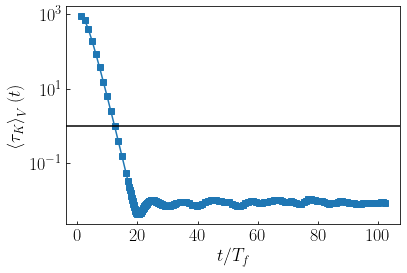

In [52]:
# find the kolmogorov time scale as a function in time:
# epsv_vol_in_time is present 

tauK_vol_in_time = np.sqrt(Pr/Ra) * 1.0/np.sqrt(epsv_vol_in_time)
plt.figure()
plt.ylabel(r'$\left < \tau_K \right > _{V} (t) $'); plt.xlabel(r'$t/T_f$')
plt.semilogy(overall_times/Tf, tauK_vol_in_time, 's-')
plt.axhline(y = 1.0, color = 'black')
#plt.xlim([20,45])

In [53]:
# read DT.dat for all files 
# use regex for cleaning this file - -- Clean and Done!

import re 

delimiters = "Step","DT=","C="," ",",","\n","\t","t=" 
regex_pattern = '|'.join(map(re.escape,delimiters))
print(regex_pattern)

# all the values for all runs in one single array
DT = np.array([]); cour = np.array([]); stdout_times = np.array([]) 

for run in nruns:
    with open('RUN' + ['','_'][int(run)>=10]
              + str(run) +'/DT.dat') as dtFile:
        
        for line in dtFile.readlines():
            each_line = [float(elem) for elem in re.split(regex_pattern, line) 
                         if elem !=''][:-2]
    
            stdout_times = np.append(stdout_times,each_line[1])
            DT = np.append(DT, each_line[2])
            cour = np.append(cour, each_line[3])


Step|DT=|C=|\ |,|\
|\	|t=


KeyboardInterrupt: 

In [ ]:
dt_at_iosteps = np.array([]); cour_at_iosteps = np.array([])

for t in overall_times:
    iloc = np.where(np.isclose(stdout_times, t, atol = 1e-4) == True)[0][0] 
    dt_at_iosteps = np.append(dt_at_iosteps, DT[iloc])
    cour_at_iosteps = np.append(cour_at_iosteps, cour[iloc])
    
print(dt_at_iosteps.size == overall_times.size == tauK_vol_in_time.size)

""" ALL LENGTHS of ALL I/O Arrays are equal."""

In [ ]:
# prepare the time resolution plot and the cfl plot 
plt.figure(figsize = [12,5])

plt.subplot(1,2,1)
plt.xlabel('$t/T_f$') 
plt.ylabel(r'$\Delta t (t)/ \left < \tau_K \right > _{V} (t) $')
plt.plot(overall_times/Tf, 
        dt_at_iosteps/tauK_vol_in_time, 'rd')
#plt.axhline(y = 1.0, color = 'k')

plt.subplot(1,2,2)
plt.xlabel('$t/T_f$') 
plt.ylabel('CFL')
plt.plot(overall_times/Tf, cour_at_iosteps, 'g-')
#plt.plot(stdout_times, cour, 'g-')

del stdout_times # too big an array

*** 

## Plot the turbulent Kinetic Energy and its mean 

- We need the files ver_rms and ver_rmsvh present. But these files are present only for a few of the latest runs. 


- Plot the vertical means for turbulent kinetic energy and its mean per run like other vertical mean stats. 


- This is a good place to test how class_RBC works


- Find the time average mean for the turbulent kinetic energy 
